# AfSIS Soil Chemistry Dataset - Modelling¶



## 1. Load libraries and data

In [1]:
#!pip install xgboost

In [80]:
import pandas as pd
from sys import stdout
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.ridge import Ridge
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import xgboost 
from xgboost import XGBRegressor

from sklearn.datasets import make_regression
from sklearn import svm
import numpy as np
import time
import statistics 
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.display import Image

from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSCanonical
from sklearn.cross_decomposition import PLSSVD


from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D,Conv2D, Reshape, MaxPooling1D
from keras.constraints import maxnorm
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.layers.noise import GaussianNoise

In [3]:
df_composition = pd.read_csv('elemental_analysis_dataset.csv')
#df_composition = df_composition.rename(columns={"P": "%P", "K": "%K","Ca": "%Ca", "Cu": "%Cu", "Fe": "%Fe", "Mo": "%Mo","Mg": "%Mg","S": "%S","Mn": "%Mn","Zn": "%Zn" , "Cl": "%Cl",})
df_composition.head()

,SSN,M3 Ca,M3 K,M3 Al,M3 P,M3 S,PH,Psa asand,Psa asilt,Psa aclay,...,Zn,Fe,Mn,Mo,Latitude,Longitude,Cluster,Depth,Country,Cultivated
0,icr006475,207.1,306.30,1095.000,4.495,18.960,4.682,97.848667,1.845333,0.306000,...,22.0,12501.3,81.9,184.5,-6.088750,36.435982,2,sub,Tanzania,False
1,icr006586,1665.0,1186.00,1165.000,12.510,13.600,7.062,89.520000,9.553667,0.926333,...,38.5,24094.6,422.4,184.5,-6.055750,36.457722,8,top,Tanzania,False
2,icr021104,258.7,35.25,441.400,4.424,3.608,5.522,89.950000,5.205000,4.845000,...,2.3,2213.4,13.2,184.5,-8.049305,37.333698,14,sub,Tanzania,False
3,icr033622,11858.3,1156.00,108.286,31.233,25.460,8.583,91.445000,6.310000,2.245000,...,29.8,24135.0,460.4,184.5,4.178087,38.261890,2,sub,Ethiopia,unknown
4,icr006570,896.2,607.30,1151.000,5.986,20.080,6.661,97.789667,1.885000,0.325667,...,13.4,9135.1,132.6,184.5,-6.069970,36.464588,7,top,Tanzania,False


In [4]:
print(df_composition.columns)

Index(['SSN', 'M3 Ca', 'M3 K', 'M3 Al', 'M3 P', 'M3 S', 'PH', 'Psa asand',
       'Psa asilt', 'Psa aclay', 'Volfr', 'Awc1', 'Lshrinkpct',
       'Flash2000_N_ppm', 'Acidified carbon', 'pH', 'Leco_N_ppm', 'C % Org',
       'ICP OES K mg/kg ', 'ICP OES P mg/kg ', 'P', 'K', 'S', 'Ca', 'Mg', 'Cu',
       'Cl', 'Zn', 'Fe', 'Mn', 'Mo', 'Latitude', 'Longitude', 'Cluster',
       'Depth', 'Country', 'Cultivated'],
      dtype='object')


## 2. Elemental analysis and soil fertility

### 2.1 Soil chemistry variables correlation

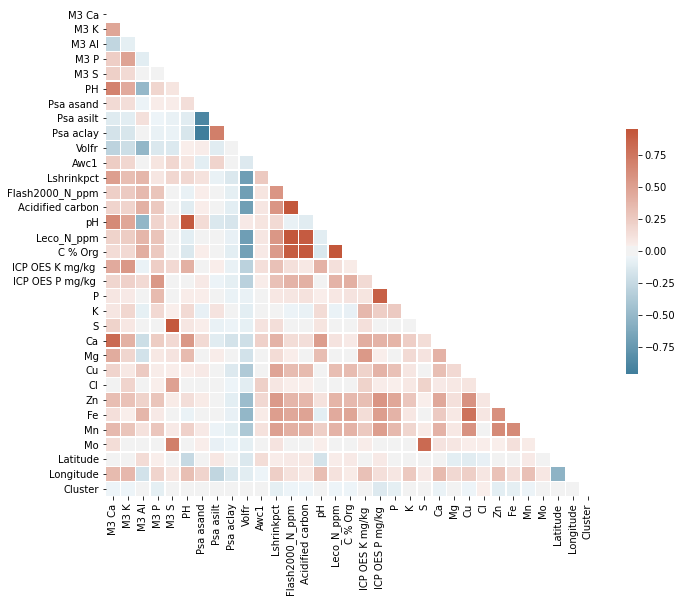

In [5]:
# Compute the correlation matrix
corr = df_composition.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.95, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The figures show poor correlation. Surprising that this is true comparing the same element concentration estimated using ICP Optical Emission Spectrometry (ICP-OES-K) and X-rays fluorescence (K)

In [6]:
selected = [ 'M3 K', 'ICP OES K mg/kg ', 'K','M3 P', 'ICP OES P mg/kg ', 'P', 'M3 S', 'S','PH','pH', 'Flash2000_N_ppm', 'Leco_N_ppm','Acidified carbon', 'C % Org']
df_corr = df_composition[selected]
df_corr.head()

,M3 K,ICP OES K mg/kg,K,M3 P,ICP OES P mg/kg,P,M3 S,S,PH,pH,Flash2000_N_ppm,Leco_N_ppm,Acidified carbon,C % Org
0,306.30,1487.768795,12991.3,4.495,83.555482,50.6,18.960,45.7,4.682,4.57,392.82719,500.0,0.429813,0.47
1,1186.00,9379.867053,15173.5,12.510,230.593961,50.6,13.600,45.7,7.062,7.06,859.46908,1100.0,0.912364,1.09
2,35.25,272.882131,6838.9,4.424,29.281256,50.6,3.608,45.7,5.522,5.27,186.29957,200.0,0.219614,0.25
3,1156.00,5259.289698,15845.8,31.233,622.223963,431.6,25.460,45.7,8.583,8.50,1026.56581,900.0,1.083015,1.01
4,607.30,2434.413016,12201.6,5.986,115.206106,50.6,20.080,45.7,6.661,6.50,377.73812,600.0,0.527140,0.62


Variance of sample set is 1.2
pH MSE 0.2


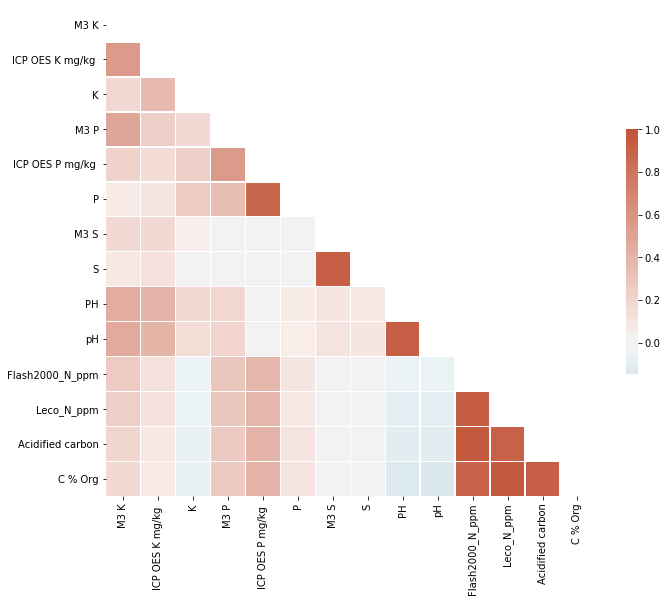

In [82]:
#max_pH = 10
ph_mse = mean_squared_error(df_corr['pH'],df_corr['PH'])
ph_rmse = np.sqrt(mean_squared_error(df_corr['pH'],df_corr['PH']))
print("Variance of sample set is % s" %(round(statistics.variance(df_corr['pH']),2)) )
print('pH MSE',np.round(ph_mse,2))
# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 2.2 Composition - fertility correlation

#### 2.2.1 Features selection

In [8]:
elemental_variables = ['pH','Flash2000_N_ppm','Awc1','P', 'K', 'S', 'Ca', 'Mg', 'Cu',
       'Cl', 'Zn', 'Fe', 'Depth', 'Cultivated']
# major and oligoelements are taken into account for the soil composition

df_composition_reduced = df_composition[elemental_variables]
print("AWC1 is a meaurement of water content")
print("Flash2000_N_ppm is a measurement of nitrogen concentration expressed in ppm")
print("acidified carbon is a measurement of % organic matter into the soil")
print('')
df_composition_reduced.head()

AWC1 is a meaurement of water content
Flash2000_N_ppm is a measurement of nitrogen concentration expressed in ppm
acidified carbon is a measurement of % organic matter into the soil



,pH,Flash2000_N_ppm,Awc1,P,K,S,Ca,Mg,Cu,Cl,Zn,Fe,Depth,Cultivated
0,4.57,392.82719,0.034962,50.6,12991.3,45.7,944.1,5575.0,13.0,210.2,22.0,12501.3,sub,False
1,7.06,859.46908,0.042649,50.6,15173.5,45.7,9301.0,5519.1,18.4,152.6,38.5,24094.6,top,False
2,5.27,186.29957,0.091913,50.6,6838.9,45.7,884.3,5575.0,2.8,229.5,2.3,2213.4,sub,False
3,8.50,1026.56581,0.159708,431.6,15845.8,45.7,46529.1,33771.2,13.0,58.2,29.8,24135.0,sub,unknown
4,6.50,377.73812,0.033089,50.6,12201.6,45.7,1790.1,5575.0,7.7,122.5,13.4,9135.1,top,False


#### 2.2.2 Categorical features encoding

In [9]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)# label encoded values of depth
enc_df = pd.DataFrame(enc.fit_transform(df_composition_reduced[['Depth']]), columns = ['depth_sub','depth_top'])

df_composition_reduced = pd.merge(df_composition_reduced, enc_df, left_index=True, right_index=True)
df_composition_reduced = df_composition_reduced.reset_index(drop = True)


In [10]:
df_composition_cultivated  = df_composition_reduced[df_composition_reduced['Cultivated'] != "unknown"]  # eliminate unknown values
print(df_composition_cultivated['Cultivated'].unique())

['False' 'True']


In [98]:
# creating instance of labelencoder for the column "Cultivated"
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])

print(df_composition_cultivated.shape)
df_composition_cultivated = df_composition_cultivated.drop(['Depth', 'Cultivated'], axis = 1)

In [105]:
pc_pos  = (df_composition_cultivated['Cultivated_n'].sum()/148)*100
print('% fertile land samples',np.round(pc_pos,1))

% fertile land samples 22.3


In [12]:
df_composition_cultivated.head()

,pH,Flash2000_N_ppm,Awc1,P,K,S,Ca,Mg,Cu,Cl,Zn,Fe,depth_sub,depth_top,Cultivated_n
0,4.57,392.82719,0.034962,50.6,12991.3,45.7,944.1,5575.0,13.0,210.2,22.0,12501.3,1.0,0.0,0
1,7.06,859.46908,0.042649,50.6,15173.5,45.7,9301.0,5519.1,18.4,152.6,38.5,24094.6,0.0,1.0,0
2,5.27,186.29957,0.091913,50.6,6838.9,45.7,884.3,5575.0,2.8,229.5,2.3,2213.4,1.0,0.0,0
4,6.50,377.73812,0.033089,50.6,12201.6,45.7,1790.1,5575.0,7.7,122.5,13.4,9135.1,0.0,1.0,0
5,5.41,2520.21961,0.112162,50.6,4731.1,45.7,4924.8,5575.0,56.1,145.1,40.6,67075.9,0.0,1.0,0


#### 2.2.3 Data modeling - logistic regression

In [13]:

X_cultivated = df_composition_cultivated.drop(['Cultivated_n'], axis = 1).values[:, 1:]

X_cult_scaled = StandardScaler().fit_transform(X_cultivated) # scale those features
y_cultivated = df_composition_cultivated['Cultivated_n'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X_cult_scaled, y_cultivated, test_size = 0.2, random_state = 42)

In [14]:
lr_cultivated = LogisticRegression(solver='liblinear',dual=True, random_state=42)

lr_cultivated.fit(X1_train, y1_train)
y1_pred = lr_cultivated.predict(X1_test) # estimation of cultivated value based on fit
accuracy_lr = lr_cultivated.score(X1_test, y1_test)
print('Score of the logistic regression model for soil composition and fertility = ',np.round(accuracy_lr,2))

Score of the logistic regression model for soil composition and fertility =  0.83


/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [15]:
cm1 = confusion_matrix(y1_test, y1_pred)

print(classification_report(y1_test, y1_pred))

df_confusionmatrix1 = pd.DataFrame(data=cm1, index=["actual negative","actual positive"], columns=["predicted negative","predicted positive"])
df_confusionmatrix1 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        27
           1       0.00      0.00      0.00         3

    accuracy                           0.83        30
   macro avg       0.45      0.46      0.45        30
weighted avg       0.80      0.83      0.82        30



,predicted negative,predicted positive
actual negative,25,2
actual positive,3,0


In [16]:
# Cross-validation
y_cv = cross_val_predict(lr_cultivated, X1_test, y1_test, cv=5)
scores = cross_val_score(lr_cultivated, X1_test, y1_test, cv=5)
scores

/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.83333333, 0.5       , 0.83333333, 0.83333333, 0.83333333])

Logistic Regression: 1-dimensional representation


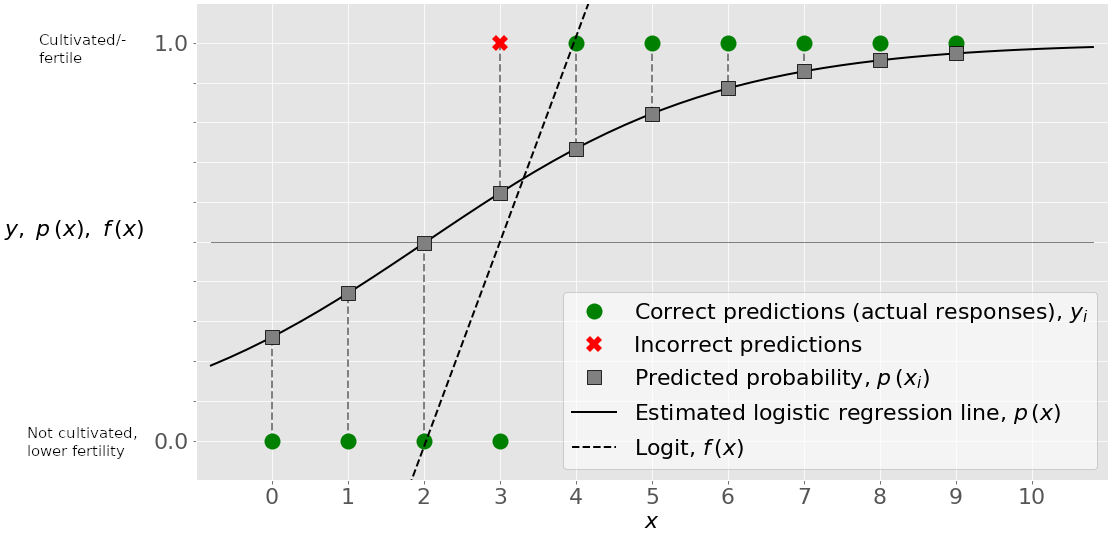

In [17]:
print("Logistic Regression: 1-dimensional representation")
Image(filename='img/logisticregression.png') 

In [18]:
n_components = 5

pca = PCA(n_components= n_components)
principalComponents = pca.fit_transform(X_cult_scaled)

df_PCA_composition = pd.DataFrame(data = principalComponents , columns = ['compositional_component1','compositional_component2','compositional_component3','compositional_component4','compositional_component5'])


print('the new component contains',pca.explained_variance_ratio_ * 100, '% of the information from the', n_components ,'variables', 'for a total of',sum(pca.explained_variance_ratio_ * 100),'%' )
#

the new component contains [30.6097796  18.49971864 15.10061963 10.03959827  7.97674046] % of the information from the 5 variables for a total of 82.22645659713287 %


In [19]:
importance = lr_cultivated.coef_[0]
cult_features = df_composition_cultivated.drop(['Cultivated_n'], axis = 1)
print('all features',cult_features.columns, len(cult_features.columns) )
names_of_variables =cult_features.columns

#create random weights and get the magnitude
weights = np.random.rand(4)
abs_weights = np.abs(importance)

#get the sorting indices
sorted_index = np.argsort(abs_weights)[::-1]

#check if the sorting indices are correct
print(abs_weights[sorted_index])

#get the index of the top-2 features
top_5 = sorted_index[:5]

#get the names of the top 2 most important features
print(names_of_variables[top_5])
ls_top5 = names_of_variables[top_5].tolist()
ls_top5[1] = 'water content'

all features Index(['pH', 'Flash2000_N_ppm', 'Awc1', 'P', 'K', 'S', 'Ca', 'Mg', 'Cu', 'Cl',
       'Zn', 'Fe', 'depth_sub', 'depth_top'],
      dtype='object') 14
[0.73846109 0.51768887 0.4817683  0.43768256 0.2221693  0.18772211
 0.12030957 0.11968293 0.11968293 0.11810195 0.07462063 0.07322147
 0.04785942]
Index(['Cl', 'Awc1', 'Ca', 'Cu', 'S'], dtype='object')


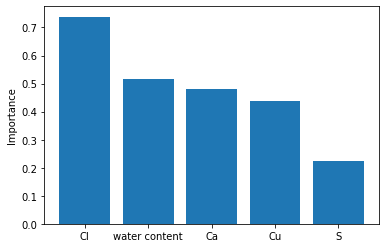

In [20]:
# plot feature importance
plt.bar(ls_top5, abs_weights[sorted_index[:5]])
plt.ylabel('Importance')
plt.show()

#### 2.2.4 Data modeling - major elements correlation

The %N cannot be detected by XRF. It is interesting then to predict it by a correlation with major elements

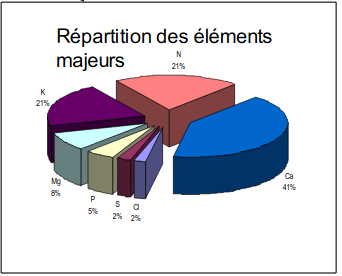

In [21]:
Image(filename='img/majorelements.png')

In [22]:
major_elements = ['Flash2000_N_ppm','P', 'K', 'S', 'Ca', 'Mg', 'Cl','Fe']
df_composition_major = df_composition[major_elements]
print(df_composition_major.shape)
df_composition_major.head()

(467, 8)


,Flash2000_N_ppm,P,K,S,Ca,Mg,Cl,Fe
0,392.82719,50.6,12991.3,45.7,944.1,5575.0,210.2,12501.3
1,859.46908,50.6,15173.5,45.7,9301.0,5519.1,152.6,24094.6
2,186.29957,50.6,6838.9,45.7,884.3,5575.0,229.5,2213.4
3,1026.56581,431.6,15845.8,45.7,46529.1,33771.2,58.2,24135.0
4,377.73812,50.6,12201.6,45.7,1790.1,5575.0,122.5,9135.1


In [23]:
#Variables selection
X_major = df_composition_major.drop(['Flash2000_N_ppm'], axis = 1).values[:, 1:]

X_maj_scaled = StandardScaler().fit_transform(X_major) # scale those features
y_maj = df_composition_major['Flash2000_N_ppm'].values

X0_train, X0_test, y0_train, y0_test = train_test_split(X_maj_scaled, y_maj, test_size = 0.2, random_state = 42)

Multilinear regression

In [24]:
reg = LinearRegression()
reg.fit(X0_train, y0_train)

y0_pred = reg.predict(X0_test)

multilinear_r2 = r2_score(y0_test,y0_pred)


# Calculate mean squared error for the regression
multilinear_mse = mean_squared_error(y0_test, y0_pred)
multilinear_rmse = np.sqrt(multilinear_mse)
print('R2: %5.3f'  % multilinear_r2)

print('RMSE: %5.3f' % multilinear_rmse)

y0_pred_scaled = y0_pred/max(y0_pred)
y0_test_scaled = y0_test/max(y0_test)
scaled_RMSE = np.sqrt(mean_squared_error(y0_test_scaled, y0_pred_scaled))
print('scaled RMSE' ,np.round(scaled_RMSE,2) )

R2: -1.187
RMSE: 1125.092
scaled RMSE 0.43


XGBoost

In [25]:
#kfold = KFold(shuffle=True, random_state=0, n_splits=4)
xgb = XGBRegressor(n_estimators=500, min_child_weight=20, n_jobs=-1, objective='reg:squarederror')

xgb.fit(X0_train, y0_train)

y_pred_xgb = xgb.predict(X0_test)#.reshape(1, 1))

# Calculate scores for the regression
xgb_score = r2_score(y0_test, y_pred_xgb)

# Calculate mean squared error for the regression
xgb_rmse = np.sqrt(mean_squared_error(y0_test, y_pred_xgb))

print('R2: %5.3f'  % xgb_score)

print('RMSE: %5.3f' % xgb_rmse)
y0_xgb_scaled = y_pred_xgb/max(y_pred_xgb)
y0_test_scaled = y0_test/max(y0_test)
scaled_RMSE = np.sqrt(mean_squared_error(y0_test_scaled, y0_xgb_scaled))
print('scaled RMSE' ,np.round(scaled_RMSE,2) )

R2: 0.366
RMSE: 605.714
scaled RMSE 0.16


Random Forest

In [26]:
rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X0_train, y0_train)

y_pred_rf = rf.predict(X0_test)#.reshape(1, 1))

# Calculate scores for the regression
rf_score = r2_score(y0_test, y_pred_rf)

# Calculate mean squared error for the regression
rf_rmse = np.sqrt(mean_squared_error(y0_test, y_pred_rf))

print('R2: %5.3f'  % rf_score)

print('RMSE: %5.3f' % rf_rmse)
y0_rf_scaled = y_pred_xgb/max(y_pred_rf)
y0_test_scaled = y0_test/max(y0_test)
scaled_RMSE = np.sqrt(mean_squared_error(y0_test_scaled, y0_rf_scaled))
print('scaled RMSE' ,np.round(scaled_RMSE,2) )

R2: 0.539
RMSE: 516.346
scaled RMSE 0.17


In [27]:
rf_importance = rf.feature_importances_
comp_features = df_composition_major.drop(['Flash2000_N_ppm'], axis = 1)
print('all features',comp_features.columns, len(comp_features.columns) )
names_of_variables =comp_features.columns

#create random weights and get the magnitude
weights = np.random.rand(4)
abs_weights = np.abs(rf_importance)

#get the sorting indices
sorted_index = np.argsort(abs_weights)[::-1]

#check if the sorting indices are correct
print(abs_weights[sorted_index])

#get the index of the top-2 features
top_5 = sorted_index[:5]

#get the names of the top 2 most important features
print(names_of_variables[top_5])
ls_top5 = names_of_variables[top_5].tolist()
ls_top5

all features Index(['P', 'K', 'S', 'Ca', 'Mg', 'Cl', 'Fe'], dtype='object') 7
[0.33644053 0.28435927 0.15141579 0.11729529 0.08574149 0.02474762]
Index(['Cl', 'K', 'P', 'Mg', 'S'], dtype='object')


['Cl', 'K', 'P', 'Mg', 'S']

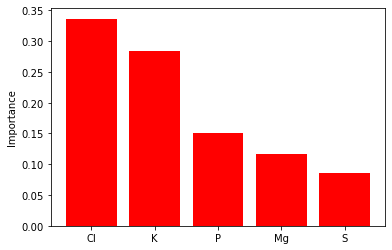

In [28]:
# plot feature importance
plt.bar(ls_top5, abs_weights[sorted_index[:5]], color = 'r')
plt.ylabel('Importance')
plt.show()

Poor correlation between elements concentration

## 3. Elemental analysis - Infrared spectroscopy correlation

### 3.1 Loading mid-infrared spectra and target variables

In [29]:
df_FTIR_raw = pd.read_csv('middle_infrared_spectra_dataset.csv')
todrop = ['SSN'] #irrelevant
df_FTIR = df_FTIR_raw.drop(todrop, axis = 1)
X = df_FTIR.values #spectra are already scaled
X_scaled = StandardScaler().fit_transform(X) 

##### Targets selection

In [89]:
df_composition['%N'] = df_composition['Flash2000_N_ppm']/1000
df_composition['%sand'] = df_composition['Psa asand']/100
# single target regression
target_feature = '%N' #['C % Org', '%P', '%K']#, '%Ca', '%Cu', '%Fe', '%Mo','pH'
# multiple targets regression
target_features = ['%N', 'pH',  '%sand']#, '%Ca', '%Cu', '%Fe', '%Mo','pH', ,  Psa asilt', 'Psa aclay', 'Volfr', 'Awc1', 'Lshrinkpct',       'Flash2000_N_ppm', 'Acidified carbon', 'pH', 'Leco_N_ppm', 'C % Org',]

y2 = df_composition[target_feature].values #PLS1 - single feature regression
Y2 = df_composition[target_features].values #PLS2 - multiple features regression
Y2_scaled = StandardScaler().fit_transform(Y2) 
print('shapes verification',y2.shape, Y2.shape)

shapes verification (467,) (467, 3)


In [96]:
#test train split
X2_train, X2_test, y2_train, y2_test = train_test_split(X_scaled, y2, test_size = 0.2, random_state = 42)

### 3.2 Multivariate linear regression

In [85]:
lr = LinearRegression()

lr_model = lr.fit(X2_train,y2_train)

y_lr = lr.predict(X2_test)  
r2_lr = r2_score(y2_test, y_lr)
rmse_lr = np.sqrt(mean_squared_error(y2_test, y_lr))
print('linear regression R²',r2_lr )
print('linear regression RMSE',rmse_lr )

linear regression R² -4.398603753886251
linear regression RMSE 1.76763619689215


Text(0.5, 1.0, 'Multivariate linear regression')

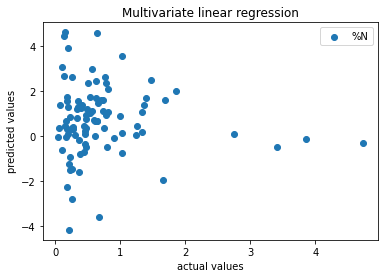

In [86]:
plt.scatter(y2_test, y_lr, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Multivariate linear regression')

### 3.3 Multivariate partial least squares (PLS) regression
#### 3.3.1 PLS1: univariate target 

NIR spectra should be correlated to COH elements, i.e. organic carbon and we investigate the correlation between these data with multivariate partial least squares regression. The predicting variables are the FTIR wavelenghts. The target is % organic C. 


In [38]:
# what is the optimal number of latent predictive features?
n_comp = 30
mse = []
r2 = []
component = np.arange(1, n_comp,2)
    
for i in component:
    pls = PLSRegression(n_components=i)
    model = pls.fit(X2_train, y2_train)
    
    y_c = model.predict(X2_test)

    mse.append(mean_squared_error(y2_test, y_c))
    r2.append(r2_score(y2_test, y_c))

Text(0.5, 0, 'Number of PLS components')

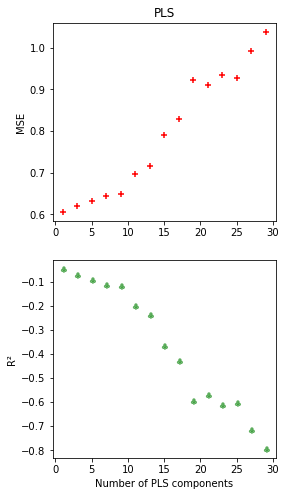

In [39]:
plt.figure(figsize= (4,8))
plt.subplot(211)
plt.scatter(component, mse, label = 'mse', marker = '+', c='r')
plt.title('PLS')
plt.ylabel('MSE')

plt.subplot(212)
plt.scatter(component, r2, label = 'R²', alpha=0.5, marker=r'$\clubsuit$', c='g')
plt.ylabel('R²')
plt.xlabel('Number of PLS components')

Now let's run this function by setting the optimized mumber of components.

In [112]:
pls = PLSRegression(n_components=20)
model_pls = pls.fit(X2_train, y2_train)

y_c = model_pls.predict(X2_test)


# Calculate score
score_c = r2_score(y2_test, y_c)



# Calculate root mean squared error 
rmse_c = np.sqrt(mean_squared_error(y2_test, y_c))

print('PLS R²: %5.3f'  % score_c)

print('PLS RMSE: %5.3f' % rmse_c)

PLS R²: -0.597
PLS RMSE: 0.961


No handles with labels found to put in legend.


Text(0.5, 1.0, 'PLS regression')

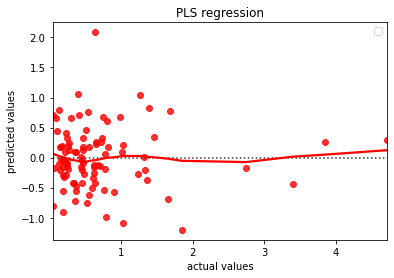

In [113]:
sns.residplot(y2_test, y_c, lowess=True, color="r")
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS regression')

#### 3.3.2 Multivariate target

- PLS canonical

In [90]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y2, test_size = 0.2, random_state = 42)

In [43]:
print('n targets: ',len(target_features))

plsca = PLSCanonical(n_components= len(target_features))
model_pls_canonical = plsca.fit(X2_train, Y2_train)
X_c, Y_c = plsca.transform(X2_test, Y2_test)



n targets:  3


In [44]:

# Calculate scores 
plsca_score_c = r2_score(Y2_test, Y_c)

# Calculate mean squared error 
plsca_mse_c = mean_squared_error(Y2_test, Y_c)


print('R² score',target_features[0],': ',r2_score(Y2_test[:,0], Y_c[:,0]))
print('R² score',target_features[1],': ',r2_score(Y2_test[:,1], Y_c[:,1]))
print('R² score',target_features[2],': ',r2_score(Y2_test[:,2], Y_c[:,2]))
#print('R² score',target_features[3],': ',r2_score(Y2_test[:,3], Y_c[:,3]))
print('')
print('R² PLS Canonical average: %5.3f'  % plsca_score_c)
print('RMSE score',target_features[0],': ',np.round(np.sqrt(mean_squared_error(Y2_test[:,0], Y_c[:,0])),2))
print('RMSE PLS Canonical average: %5.3f' % np.round(np.sqrt(plsca_mse_c),2))


R² score %N :  -0.18514679707524984
R² score pH :  -33.07396764367303
R² score %sand :  -48.144788339965494

R² PLS Canonical average: -27.135
RMSE score %N :  0.83
RMSE PLS Canonical average: 3.610


[]

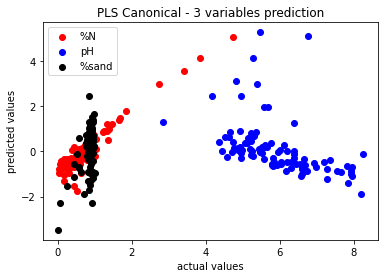

In [45]:
plt.scatter(Y2_test[:,0], Y_c[:,0], label = target_features[0], color = 'r')
plt.scatter(Y2_test[:,1], Y_c[:,1], label = target_features[1], color = 'b')
plt.scatter(Y2_test[:,2], Y_c[:,2], label = target_features[2], color = 'k')
#plt.scatter(Y2_test[:,3], Y_c[:,3], label = target_features[3], color = 'g')
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS Canonical - 3 variables prediction')
plt.plot()

### 3.4 Random forest regression

#### 3.4.1 One target variable

In [87]:
X2, y2 = make_regression(n_features=len(df_FTIR.columns), n_informative=150,random_state=0, shuffle=False)

rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X2_train, y2_train)
y_pred_rf = rf.predict(X2_test)#.reshape(1, 1))

# Calculate score R2
rf_score_c = r2_score(y2_test, y_pred_rf)

# Calculate root mean squared error
rf_rmse_c = np.sqrt(mean_squared_error(y2_test, y_pred_rf))

print('random forest regression R²: %5.3f'  % rf_score_c)

print('random forest regression RMSE: %5.3f' % np.round(rf_rmse_c,2))

random forest regression R²: -0.180
random forest regression RMSE: 0.830


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Random forest regression')

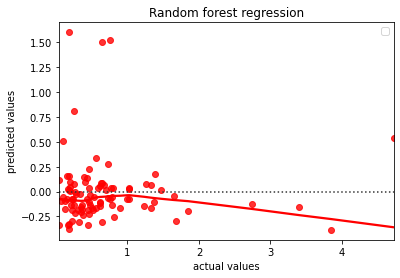

In [37]:
sns.residplot(y2_test, y_pred_rf, lowess=True, color="r")
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Random forest regression')

#### 3.4.2 Multivariate target

In [91]:

#X2, y2 = make_regression(n_features=len(df_FTIR.columns), n_informative=150,random_state=0, shuffle=False)

rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X2_train, Y2_train)
Y_pred_rf = rf.predict(X2_test)#.reshape(1, 1))

# Calculate score R2
rf_score_c = r2_score(Y2_test, Y_pred_rf)

# Calculate root mean squared error
rf_rmse_c = np.sqrt(mean_squared_error(Y2_test, Y_pred_rf))

print('random forest regression R²: %5.3f'  % rf_score_c)

print('random forest regression RMSE: %5.3f' % np.round(rf_rmse_c,2))


random forest regression R²: -0.070
random forest regression RMSE: 0.780


In [97]:

# Calculate scores 
RF_score = r2_score(Y2_test, Y_pred_rf)

# Calculate mean squared error 
RF_MSE = mean_squared_error(Y2_test, Y_pred_rf)


print('R² score',target_features[0],': ',r2_score(Y2_test[:,0], Y_pred_rf[:,0]))
print('R² score',target_features[1],': ',r2_score(Y2_test[:,1], Y_pred_rf[:,1]))
print('R² score',target_features[2],': ',r2_score(Y2_test[:,2], Y_pred_rf[:,2]))
#print('R² score',target_features[3],': ',r2_score(Y2_test[:,3], Y_c[:,3]))
print('')
print('R² RF average: %5.3f'  % RF_score)
print('RMSE RF score',target_features[0],': ',np.round(np.sqrt(mean_squared_error(Y2_test[:,0], Y_pred_rf[:,0])),2))
print('RMSE Random Forest average: %5.3f' % np.round(np.sqrt(RF_MSE),2))


R² score %N :  -0.14604758535058426
R² score pH :  -0.050488510389144814
R² score %sand :  -0.01440851542187449

R² RF average: -0.070
RMSE RF score %N :  0.81
RMSE Random Forest average: 0.780


[]

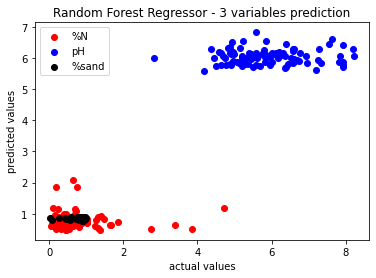

In [95]:
plt.scatter(Y2_test[:,0], Y_pred_rf[:,0], label = target_features[0], color = 'r')
plt.scatter(Y2_test[:,1], Y_pred_rf[:,1], label = target_features[1], color = 'b')
plt.scatter(Y2_test[:,2], Y_pred_rf[:,2], label = target_features[2], color = 'k')
#plt.scatter(Y2_test[:,3], Y_c[:,3], label = target_features[3], color = 'g')
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Random Forest Regressor - 3 variables prediction')
plt.plot()

## 4. Convolutional neural network for chemiometrics

Results can be improved as described in https://www.sciencedirect.com/science/article/abs/pii/S0016706119302368

- algorithm can be modified
- FTIR data can be further processed

### 4.1 Published convolutional neural network (CNN)

In [46]:
#X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y2, test_size = 0.2, random_state = 42)
#Y2_pc = Y2/10000 # % instead of PPM

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y2, test_size=0.2, random_state=42)
X2_train, X2_val, Y2_train, Y2_val = train_test_split(X2_train, Y2_train, test_size=0.1, random_state=1)

#### 4.1.1 CNN used for chemiometrics in the literature
https://github.com/EBjerrum/Deep-Chemometrics

In [47]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = 0.5
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 16 #Width of the convolutional mini networks
C2_K  = 32
C2_S  = 16

activation='relu'

input_dim = X2_train.shape[1]

#The model
def make_model1():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, padding="same"))
    model.add(Conv1D(C2_K, (C2_S), padding="same", activation=activation))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(Y2_train.shape[1], activation='linear'))

    model.compile(loss='mse', metrics=['accuracy'], optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])

    return model

In [48]:
original_model = make_model1()
print(original_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 2542)              0         
_________________________________________________________________
reshape (Reshape)            (None, 2542, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2542, 8)           136       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2542, 32)          4128      
_________________________________________________________________
flatten (Flatten)            (None, 81344)             0         
_________________________________________________________________
dropout (Dropout)            (None, 81344)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [49]:
rdlr = ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h1 = original_model.fit(X2_train, Y2_train, epochs=100, batch_size=4, validation_data=(X2_val, Y2_val), callbacks=[rdlr])

Epoch 1/100
84/84 [==============================] - 4s 52ms/step - loss: 1.2384 - accuracy: 1.0000 - val_loss: 0.9298 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 2/100
84/84 [==============================] - 5s 54ms/step - loss: 0.9185 - accuracy: 1.0000 - val_loss: 0.9777 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 3/100
84/84 [==============================] - 4s 53ms/step - loss: 0.9426 - accuracy: 1.0000 - val_loss: 0.8706 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 4/100
84/84 [==============================] - 4s 51ms/step - loss: 0.9111 - accuracy: 1.0000 - val_loss: 1.0194 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 5/100
84/84 [==============================] - 4s 50ms/step - loss: 0.7976 - accuracy: 1.0000 - val_loss: 0.9191 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 6/100
84/84 [==============================] - 4s 50ms/step - loss: 0.8195 - accuracy: 1.0000 - val_loss: 0.8399 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 7/100
84/84 [==============================] - 4s 49ms/step - lo

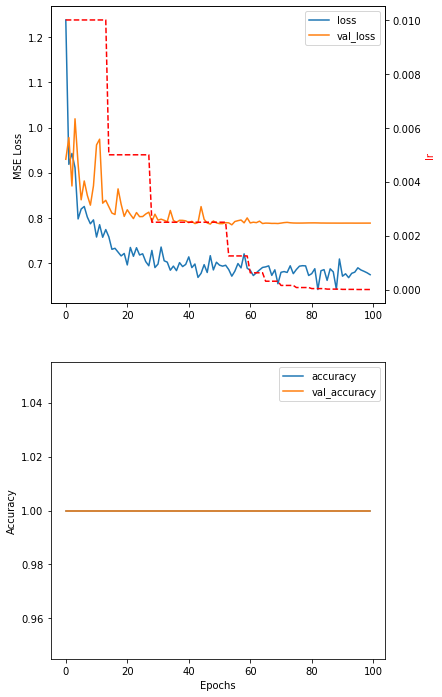

In [50]:
#fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plt.figure(figsize= (6,12))
plt.subplot(211)
plt.plot(h1.history['loss'], label='loss')
plt.plot(h1.history['val_loss'], label='val_loss')
plt.ylabel('MSE Loss')
#plt.xticks(epochs," ")
_ = plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h1.history['lr'], color='r', linestyle='dashed')
ax2.set_ylabel('lr',color='r')


plt.subplot(212)
plt.plot(h1.history['accuracy'], label='accuracy')
plt.plot(h1.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')




_ = plt.legend()

#### 4.1.2 CNN with additional layers

Modified model

In [51]:
#Hyperparameters for the network
DENSE = 100
DROPOUT = 0.3
C1_K  = 32 #Number of kernels/feature extractors for first layer
C1_S  = 20 #Width of the convolutional mini networks
C2_K  = 64
C2_S  = 20
C3_K  = 128
C3_S  = 20
C4_K  = 256
C4_S  = 20

activation='relu'

input_dim = X2_train.shape[1]

#The model
def make_model():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.02, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, padding="same"))
    model.add(MaxPooling1D(pool_size=2, padding='valid'))
    model.add(Conv1D(C2_K, (C2_S), padding="same", activation=activation))
    model.add(MaxPooling1D(pool_size=5, padding='valid'))
    model.add(Conv1D(C3_K, (C3_S), padding="same", activation=activation))
    model.add(MaxPooling1D(pool_size=5, padding='valid'))
    model.add(Conv1D(C4_K, (C4_S), padding="same", activation=activation))
    model.add(MaxPooling1D(pool_size=5, padding='valid'))
    
    model.add(Flatten())
    
    model.add(Dense(1028, activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    model.add(Dense(256, activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    model.add(Dense(128, activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation='swish'))
    model.add(Dense(Y2_train.shape[1], activation='linear'))

    #model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.005))#, metrics=['mean_absolute_error'])
    model.compile(loss='mse', metrics=['accuracy'], optimizer=keras.optimizers.Adadelta(lr=0.005))#, metrics=['mean_absolute_error'])
     
    return model



In [52]:
model = make_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 2542)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2542, 1)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2542, 32)          672       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1271, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1271, 64)          41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 254, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 254, 128)         

In [53]:
rdlr = ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X2_train, Y2_train, epochs=100, batch_size=4, validation_data=(X2_val, Y2_val), callbacks=[rdlr])

Epoch 1/100
84/84 [==============================] - 4s 48ms/step - loss: 11.8991 - accuracy: 0.3463 - val_loss: 12.8959 - val_accuracy: 1.0000 - lr: 0.0050
Epoch 2/100
84/84 [==============================] - 4s 47ms/step - loss: 10.9021 - accuracy: 0.3582 - val_loss: 12.6345 - val_accuracy: 0.3421 - lr: 0.0050
Epoch 3/100
84/84 [==============================] - 4s 46ms/step - loss: 9.8980 - accuracy: 0.4448 - val_loss: 12.3687 - val_accuracy: 0.2368 - lr: 0.0050
Epoch 4/100
84/84 [==============================] - 4s 44ms/step - loss: 9.3189 - accuracy: 0.5015 - val_loss: 12.6331 - val_accuracy: 0.9737 - lr: 0.0050
Epoch 5/100
84/84 [==============================] - 4s 50ms/step - loss: 8.6981 - accuracy: 0.5642 - val_loss: 9.2094 - val_accuracy: 0.8947 - lr: 0.0050
Epoch 6/100
84/84 [==============================] - 4s 48ms/step - loss: 8.2660 - accuracy: 0.6000 - val_loss: 6.1647 - val_accuracy: 0.8421 - lr: 0.0050
Epoch 7/100
84/84 [==============================] - 4s 45ms/ste

Text(0, 0.5, 'lr')

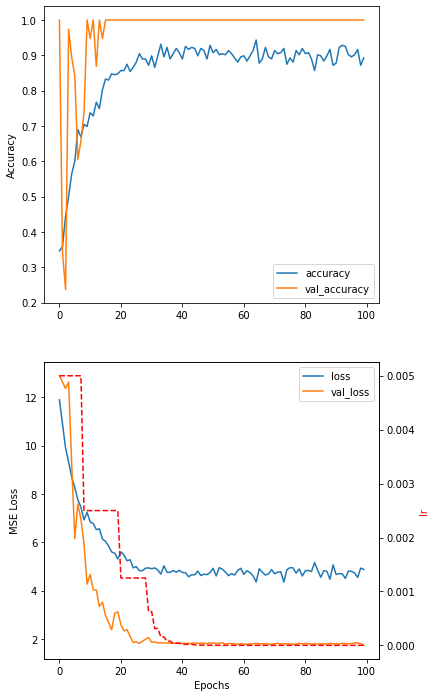

In [188]:
#fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plt.figure(figsize= (6,12))
plt.subplot(211)
plt.plot(h.history['accuracy'], label='accuracy')
plt.plot(h.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')

#plt.xticks(epochs," ")
_ = plt.legend()



plt.subplot(212)
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')

_ = plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r', linestyle='dashed')
ax2.set_ylabel('lr',color='r')




In [55]:
Y2_pred = model.predict(X2_test)
print(Y2_pred.shape, Y2_test.shape)

(94, 3) (94, 3)


In [56]:
model_R2 = np.sqrt(r2_score(Y2_test, Y2_pred))

# Calculate mean squared error 
model_RMSE = np.sqrt(mean_squared_error(Y2_test, Y2_pred))


print('R² score',target_features[0],': ',r2_score(Y2_test[:,0], Y2_pred[:,0]))
print('R² score',target_features[1],': ',r2_score(Y2_test[:,1], Y2_pred[:,1]))
print('R² score',target_features[2],': ',r2_score(Y2_test[:,2], Y2_pred[:,2]))
#print('R² score',target_features[3],': ',r2_score(Y2_test[:,3], Y2_pred[:,3]))
print('')
print('R² CNN:', model_R2)
print('RMSE score',target_features[0],': ',np.round(np.sqrt(mean_squared_error(Y2_test[:,0], Y2_pred[:,0])),2))
print('RMSE CNN average: %5.3f' % np.round(model_RMSE,2))

R² score %N :  -1.613130923301938
R² score pH :  -2.108750706582395
R² score %sand :  -12.153247920532396

R² CNN: nan
RMSE score %N :  1.23
RMSE CNN average: 1.330


<ipython-input-56-2342acd03527>:1: RuntimeWarning: invalid value encountered in sqrt
  model_R2 = np.sqrt(r2_score(Y2_test, Y2_pred))


[]

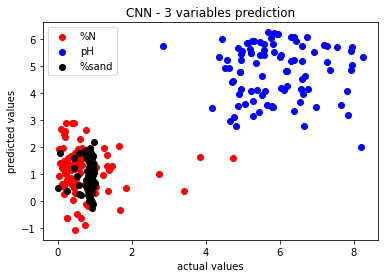

In [57]:

plt.scatter(Y2_test[:,0], Y2_pred[:,0], label = target_features[0], color = 'r')
plt.scatter(Y2_test[:,1], Y2_pred[:,1], label = target_features[1], color = 'b')
plt.scatter(Y2_test[:,2], Y2_pred[:,2], label = target_features[2], color = 'k')
#plt.scatter(Y2_test[:,3], Y2_pred[:,3], label = target_features[3], color = 'g')
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('CNN - 3 variables prediction')
plt.plot()

In [58]:
Y2_origpred = original_model.predict(X2_test)
print(Y2_origpred.shape, Y2_test.shape)

(94, 3) (94, 3)


In [59]:
origmodel_R2 = np.sqrt(r2_score(Y2_test, Y2_origpred))

# Calculate mean squared error 
origmodel_RMSE = np.sqrt(mean_squared_error(Y2_test, Y2_origpred))


print('R² score',target_features[0],': ',r2_score(Y2_test[:,0], Y2_origpred[:,0]))
print('R² score',target_features[1],': ',r2_score(Y2_test[:,1], Y2_origpred[:,1]))
print('R² score',target_features[2],': ',r2_score(Y2_test[:,2], Y2_origpred[:,2]))
#print('R² score',target_features[3],': ',r2_score(Y2_test[:,3], Y2_origpred[:,3]))
print('')
print('R² CNN:', origmodel_R2)
print('RMSE score',target_features[0],': ',np.round(np.sqrt(mean_squared_error(Y2_test[:,0], Y2_origpred[:,0])),2))
print('RMSE CNN average: %5.3f' % np.round(origmodel_RMSE,2))

R² score %N :  -0.04661099525158896
R² score pH :  -0.08472233755908531
R² score %sand :  -0.04207622349009843

R² CNN: nan
RMSE score %N :  0.78
RMSE CNN average: 0.780


<ipython-input-59-749d2fe7346d>:1: RuntimeWarning: invalid value encountered in sqrt
  origmodel_R2 = np.sqrt(r2_score(Y2_test, Y2_origpred))


[]

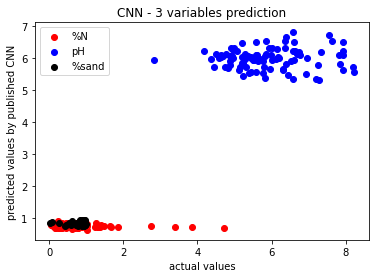

In [60]:

plt.scatter(Y2_test[:,0], Y2_origpred[:,0], label = target_features[0], color = 'r')
plt.scatter(Y2_test[:,1], Y2_origpred[:,1], label = target_features[1], color = 'b')
plt.scatter(Y2_test[:,2], Y2_origpred[:,2], label = target_features[2], color = 'k')
#plt.scatter(Y2_test[:,3], Y2_origpred[:,3], label = target_features[3], color = 'g')
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values by published CNN')
plt.title('CNN - 3 variables prediction')
plt.plot()

## 5. Spectral reduction and baseline correction

### 5.1 FTIR spectra baseline correction by differentiation

2542
(467, 2542)


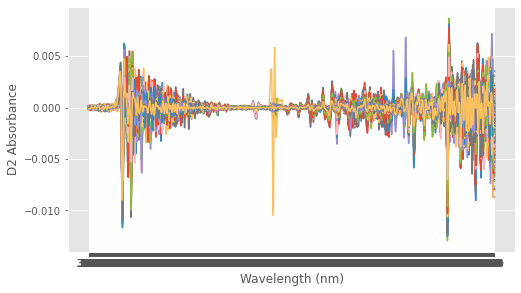

In [61]:


# Get wavelengths
wavelenghts_list = df_FTIR.columns.tolist() 
wavelenghts = np.array(wavelenghts_list)
print(len(wavelenghts))


# Calculate second derivative. That should average baselines
X2 = savgol_filter(X, 17, polyorder = 2,deriv=2)
print(X2.shape)
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wavelenghts, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

In [62]:
y2 = df_composition[target_feature].values
X3_train, X3_test, y3_train, y3_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

pls = PLSRegression(n_components=10)
model_pls = pls.fit(X3_train, y3_train)

y3_c = model_pls.predict(X3_test)


# Calculate scores for calibration and cross-validation
score3_c = r2_score(y3_test, y3_c)



# Calculate mean squared error for calibration and cross validation
rmse3_c = np.sqrt(mean_squared_error(y3_test, y3_c))

print('PLS R² after spectra differentiation: %5.3f'  % score3_c,'vs.',score_c,'for primitive wave functions')

print('PLS RMSE after spectra differentiation: %5.3f' % rmse3_c,'vs.',rmse_c,'for primitive wave functions')

PLS R² after spectra differentiation: -1.180 vs. -0.5954643262899628 for primitive wave functions
PLS RMSE after spectra differentiation: 1.123 vs. 0.9609387553175943 for primitive wave functions


Text(0.5, 1.0, 'PLS regression for FTIR derivative function')

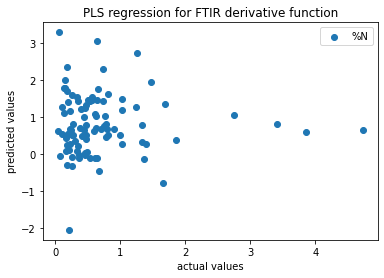

In [63]:
plt.scatter(y3_test, y3_c, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS regression for FTIR derivative function')

### 5.2 FTIR spectra reduction

I select only the regions containing the peaks corresponding to C=O and C=C bonds and filter away the rest of the spectrum containing either a flat or a noisy curve

In [64]:
FTIR_spectra = pd.read_csv('MIR_spectra_transposed.csv')

In [65]:
print(len(FTIR_spectra.labda))

2542


FTIR spectrum example


Text(0.5, 0, 'Wavelengths (cm-1)')

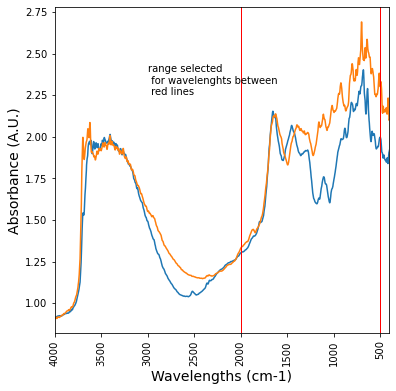

In [114]:
wavelenght_lower_limit = 500
wavelenght_upper_limit = 2000
print('FTIR spectrum example')
plt.figure(figsize= (6,6))

 
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr033603'])
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr048642'])
plt.axvline(x= wavelenght_upper_limit , ymin=0, ymax=1, color='r', linewidth = 1)
plt.axvline(x= wavelenght_lower_limit , ymin=0, ymax=1, color='r', linewidth = 1)
plt.text(3000, 2.25, 'range selected \n for wavelenghts between \n red lines')
plt.xticks(rotation=90)
plt.xlim(4000,400)
plt.ylabel('Absorbance (A.U.)', fontsize=14)
plt.xlabel('Wavelengths (cm-1)', fontsize = 14)

Text(0.5, 0, 'Wavelengths (cm-1)')

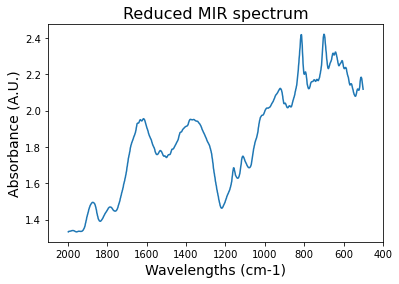

In [115]:
df_MIR_FTIRspectra =  FTIR_spectra[FTIR_spectra['labda'] > wavelenght_lower_limit]  
df_MIR_FTIRspectra = df_MIR_FTIRspectra[df_MIR_FTIRspectra['labda'] < wavelenght_upper_limit] 

plt.plot(df_MIR_FTIRspectra['labda'],df_MIR_FTIRspectra['icr042897']) 
plt.xlim( wavelenght_upper_limit+100,wavelenght_lower_limit-100)
plt.title('Reduced MIR spectrum', fontsize=16)
plt.ylabel('Absorbance (A.U.)', fontsize=14)
plt.xlabel('Wavelengths (cm-1)', fontsize = 14)

In [116]:
df_FTIR_reindexed = df_MIR_FTIRspectra.set_index('labda')
mid_infrared_df = df_FTIR_reindexed.T.reset_index()
mid_infrared_df = mid_infrared_df.rename(columns={'index': 'SSN'})

In [117]:
sampleslist = df_composition['SSN'].tolist()
print('before selection',mid_infrared_df.shape)
mid_infrared_df = mid_infrared_df[mid_infrared_df['SSN'].isin(sampleslist)]
print('after selection',mid_infrared_df.shape)
mid_infrared_df = mid_infrared_df.drop(['SSN'], axis = 1)

before selection (1888, 1059)
after selection (467, 1059)


In [118]:
X4 = mid_infrared_df.values
y4 = df_composition[target_feature].values

print(X4.shape, y4.shape)

(467, 1058) (467,)


In [191]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state = 42)

pls = PLSRegression(n_components=10)
model_pls = pls.fit(X4_train, y4_train)

y4_c = model_pls.predict(X4_test)


# Calculate scores for calibration and cross-validation
score4_c = r2_score(y4_test, y4_c)



# Calculate mean squared error for calibration and cross validation
mse4_c = mean_squared_error(y4_test, y4_c)

print('PLS R² after spectra reduction: %5.3f'  % score4_c,'vs.',score_c,'for full spectra')

print('PLS RMSE after spectra reduction: %5.3f' % np.sqrt(mse4_c),'vs.',rmse_c,'for full spectra')

PLS R² after spectra reduction: -0.127 vs. -0.5967031493414543 for full spectra
PLS RMSE after spectra reduction: 0.808 vs. 0.961311750836408 for full spectra


## 6. Verify linear correlation 

Law of Lambert Beer suggests linear correlation


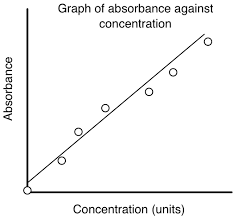

In [173]:
print('Law of Lambert Beer suggests linear correlation')
Image(filename='img/linear.png')

In [174]:
df_composition = df_composition.sort_values(by=['pH'])
df_PH = df_composition[['SSN','pH','PH']]
df_PH['diff'] = df_PH['pH'] - df_PH['PH']
df_PH

<ipython-input-174-0054089c12cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PH['diff'] = df_PH['pH'] - df_PH['PH']


,SSN,pH,PH,diff
311,icr068677,2.84,8.320,-5.480
276,icr068101,3.89,4.180,-0.290
290,icr068322,4.12,4.220,-0.100
265,icr062195,4.13,4.190,-0.060
289,icr068321,4.17,4.220,-0.050
...,...,...,...,...
166,icr033393,8.59,9.205,-0.615
158,icr075756,8.73,7.120,1.610
170,icr033467,9.05,9.214,-0.164
159,icr075757,9.38,9.720,-0.340


Text(0, 0.5, 'difference between the two labs measurement')

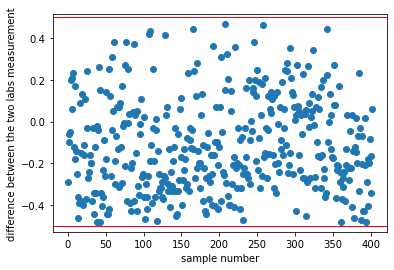

In [190]:
xph = np.arange(len(df_PH.index))
plt.scatter(xph,df_PH['diff'])

plt.axhline(y=.5, xmin=0, xmax=500,color='r', linewidth = 1)
plt.axhline(y=-0.5, xmin=0, xmax=500,color='r', linewidth = 1)
plt.xlabel('sample number')
plt.ylabel('difference between the two labs measurement')

In [176]:
df_PH = df_PH[df_PH['diff'] < 0.5]  
df_PH = df_PH[df_PH['diff'] > -0.5]  
print(df_PH.shape)

(403, 4)


In [177]:
df_PH_FTIR = pd.merge(left=df_PH, right=df_FTIR_raw, left_on='SSN', right_on='SSN').sort_values(by=['PH'])
print(df_PH_FTIR.shape)
df_PH_FTIR.head()

(403, 2546)


,SSN,pH,PH,diff,3998,3997,3996,3994,3993,3991,...,412,411,409,408,406,405,404,402,401,399
4,icr062175,4.20,4.00,0.20,0.787581,0.788137,0.788412,0.788415,0.788219,0.787929,...,2.043272,2.042429,2.042811,2.044874,2.049155,2.055884,2.064780,2.075154,2.086159,2.096880
5,icr068381,4.22,4.01,0.21,0.823309,0.823787,0.824382,0.824995,0.825560,0.826082,...,1.989507,2.004840,2.022895,2.040807,2.053985,2.058005,2.050506,2.031779,2.004429,1.973044
7,icr068382,4.29,4.06,0.23,0.834674,0.835663,0.836557,0.837386,0.838197,0.839024,...,2.075219,2.072237,2.070053,2.068897,2.069716,2.073739,2.081663,2.092782,2.104237,2.110837
0,icr068101,3.89,4.18,-0.29,0.885259,0.885662,0.886088,0.886574,0.887100,0.887618,...,2.202463,2.206593,2.216625,2.232258,2.250889,2.267877,2.277374,2.274044,2.255781,2.226002
2,icr062195,4.13,4.19,-0.06,0.769183,0.769078,0.769096,0.769320,0.769739,0.770266,...,2.252506,2.260601,2.265513,2.267597,2.265792,2.259664,2.248696,2.230576,2.202916,2.166067


In [178]:
lowest_pH = df_PH_FTIR.loc[:,'pH'] < 4.2
lowest_pH_samples = df_PH_FTIR.SSN[lowest_pH]
print(lowest_pH_samples)

0    icr068101
2    icr062195
1    icr068322
3    icr068321
Name: SSN, dtype: object


In [179]:
highest_pH = df_PH_FTIR.loc[:,'pH'] > 8.5
highest_pH_samples = df_PH_FTIR.SSN[highest_pH]
print(highest_pH_samples)

400    icr033467
401    icr075757
402    icr072857
Name: SSN, dtype: object


Text(0.5, 0, 'Wavelengths (cm-1)')

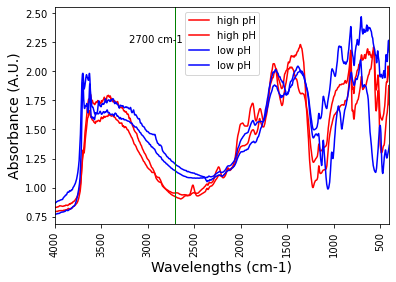

In [180]:
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr033467'], label = 'high pH', color = 'r')
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr072857'], label = 'high pH', color = 'r')
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr062195'], label = 'low pH', color = 'b')
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr068322'], label = 'low pH', color = 'b')

plt.axvline(x= 2700 , ymin=0, ymax=1, color='g', linewidth = 1)
plt.text(3200, 2.25, '2700 cm-1')



plt.legend()
plt.xticks(rotation=90)
plt.xlim(4000,400)
plt.ylabel('Absorbance (A.U.)', fontsize=14)
plt.xlabel('Wavelengths (cm-1)', fontsize = 14)

Text(0, 0.5, 'Absorbance')

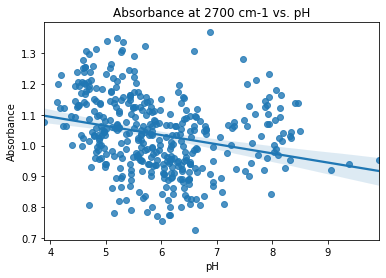

In [186]:
ax = sns.regplot(x="pH", y="2700", data=df_PH_FTIR)
plt.title('Absorbance at 2700 cm-1 vs. pH')
plt.ylabel('Absorbance')

In [182]:
x_PH = df_PH_FTIR['2700'].values
y_PH = df_PH_FTIR['pH'].values

Xph_train, Xph_test, yph_train, yph_test = train_test_split(x_PH, y_PH, test_size = 0.2, random_state = 42)

Xph_train = Xph_train.reshape(-1,1) 
Xph_test = Xph_test.reshape(-1,1)


reg = LinearRegression()

reg.fit(Xph_train, yph_train)

yph_pred = reg.predict(Xph_test)

linear_r2 = r2_score(yph_test,yph_pred)


# Calculate mean squared error for the regression
linear_mse = mean_squared_error(yph_test, yph_pred)
linear_rmse = np.sqrt(linear_mse)
print('R2: %5.3f'  % linear_r2)

print('RMSE: %5.3f' % linear_rmse)


R2: 0.075
RMSE: 1.085
